<a href="https://colab.research.google.com/github/jrangelg/Artificial-intelligence/blob/main/Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Redes Neuronales Artificiales

Las **Redes Neuronales Artificiales (RNA)** son modelos matemáticos inspirados en el
funcionamiento del cerebro humano. Se utilizan para aproximar funciones,
clasificar datos y resolver problemas de regresión y reconocimiento de patrones.

---

# 1. Neurona Artificial

Una neurona artificial recibe entradas $x_1, x_2, \dots, x_p$ y calcula:

$$
z = \sum_{j=1}^{p} w_j x_j + b
$$

donde:

- $w_j$ son los pesos
- $b$ es el sesgo (bias)

Luego aplica una función de activación $\phi(\cdot)$:

$$
a = \phi(z)
$$

---

# 2. Funciones de Activación

## Sigmoide

$$
\phi(z) = \frac{1}{1 + e^{-z}}
$$

## ReLU

$$
\phi(z) = \max(0,z)
$$

## Tanh

$$
\phi(z) = \tanh(z)
$$

---

# 3. Red Neuronal Multicapa (MLP)

Una red con una capa oculta puede escribirse como:

$$
a^{(1)} = \phi(W^{(1)}x + b^{(1)})
$$

$$
\hat{y} = W^{(2)}a^{(1)} + b^{(2)}
$$

En forma general para $L$ capas:

$$
a^{(l)} = \phi\left(W^{(l)} a^{(l-1)} + b^{(l)}\right)
$$

---

# 4. Función de Pérdida

Para regresión:

$$
\mathcal{L} =
\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2
$$

Para clasificación binaria:

$$
\mathcal{L} =
-\frac{1}{n}\sum_{i=1}^{n}
\left[
y_i \log(\hat{y}_i)
+
(1-y_i)\log(1-\hat{y}_i)
\right]
$$

---

# 5. Entrenamiento: Descenso por Gradiente

Los parámetros $\theta = \{W,b\}$ se actualizan mediante:

$$
\theta_{t+1}
=
\theta_t
-
\eta
\nabla_\theta \mathcal{L}
$$

donde:

- $\eta$ es la tasa de aprendizaje
- $\nabla_\theta \mathcal{L}$ es el gradiente

El cálculo eficiente del gradiente se realiza mediante **Backpropagation**.

---

# 6. Teorema de Aproximación Universal

Una red neuronal con:

- Una sola capa oculta
- Activación no lineal

puede aproximar cualquier función continua en un conjunto compacto
con precisión arbitraria.

---

# 7. Interpretación Estadística

Una red neuronal puede verse como:

- Un modelo no lineal paramétrico
- Un estimador flexible de funciones
- Una generalización del modelo de regresión

---


Las redes neuronales combinan:

- Álgebra lineal
- Cálculo diferencial
- Optimización numérica
- Probabilidad y estadística

y constituyen una herramienta central en **Machine Learning moderno**.


In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import pandas as pd

spark = SparkSession.builder.appName("RegresionMultipleIris").getOrCreate()

iris = sns.load_dataset("iris")
pdf = iris[["sepal_length", "sepal_width", "petal_length", "petal_width"]]

df = spark.createDataFrame(pdf)

df.createOrReplaceTempView("iris_table")

df_sql = spark.sql("""
    SELECT
        sepal_length AS y,
        sepal_width,
        petal_length,
        petal_width
    FROM iris_table
""")

assembler = VectorAssembler(
    inputCols=["sepal_width", "petal_length", "petal_width"],
    outputCol="features"
)

data_modelo = assembler.transform(df_sql).select("features", "y")

lr = LinearRegression(featuresCol="features", labelCol="y")

modelo = lr.fit(data_modelo)

predicciones = modelo.transform(data_modelo)

evaluador = RegressionEvaluator(
    labelCol="y",
    predictionCol="prediction",
    metricName="r2"
)

print("Intercepto:", modelo.intercept)
print("Coeficientes:", modelo.coefficients)
print("R2:", evaluador.evaluate(predicciones))

spark.stop()


Intercepto: 1.855997492917044
Coeficientes: [0.6508371593133332,0.709131959136832,-0.5564826601672251]
R2: 0.8586117200663177


In [4]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

iris = sns.load_dataset("iris")

X = iris[["sepal_width", "petal_length", "petal_width"]].values
y = iris["sepal_length"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = keras.Sequential([
    layers.Dense(16, activation="relu", input_shape=(3,)),
    layers.Dense(8, activation="relu"),
    layers.Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

loss, mae = model.evaluate(X_test, y_test, verbose=0)

print("Test MSE:", loss)
print("Test MAE:", mae)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 33.8670 - mae: 5.7304 - val_loss: 37.5184 - val_mae: 6.0613
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 32.2597 - mae: 5.5978 - val_loss: 36.5692 - val_mae: 5.9826
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 32.8581 - mae: 5.6523 - val_loss: 35.6365 - val_mae: 5.9043
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 29.9859 - mae: 5.3854 - val_loss: 34.7268 - val_mae: 5.8266
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 30.2741 - mae: 5.4133 - val_loss: 33.8280 - val_mae: 5.7488
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 30.9013 - mae: 5.4773 - val_loss: 32.9347 - val_mae: 5.6704
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 28.7247 - mae: 5.2821 - val_loss: 32.0488 - val_mae: 5.5910
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 27.5671 - mae: 5.1654 - val_loss: 31.1749 - val_mae: 5.5117
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 26.5504 - 

In [5]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Datos
iris = sns.load_dataset("iris")
X = iris[["sepal_width", "petal_length", "petal_width"]].values
y = iris["sepal_length"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# 1. Regresión Lineal Múltiple
# =========================
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# =========================
# 2. Red Neuronal
# =========================
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

model = keras.Sequential([
    layers.Dense(16, activation="relu", input_shape=(3,)),
    layers.Dense(8, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.fit(X_train_s, y_train, epochs=100, batch_size=16, verbose=0)

y_pred_nn = model.predict(X_test_s).flatten()

# =========================
# Métricas
# =========================
metricas = pd.DataFrame({
    "Modelo": ["Regresión Lineal", "Red Neuronal"],
    "MSE": [
        mean_squared_error(y_test, y_pred_lr),
        mean_squared_error(y_test, y_pred_nn)
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_nn)
    ],
    "R2": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_nn)
    ]
})

print(metricas)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
             Modelo       MSE       MAE        R2
0  Regresión Lineal  0.102126  0.234129  0.852048
1      Red Neuronal  0.158577  0.327905  0.770268


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


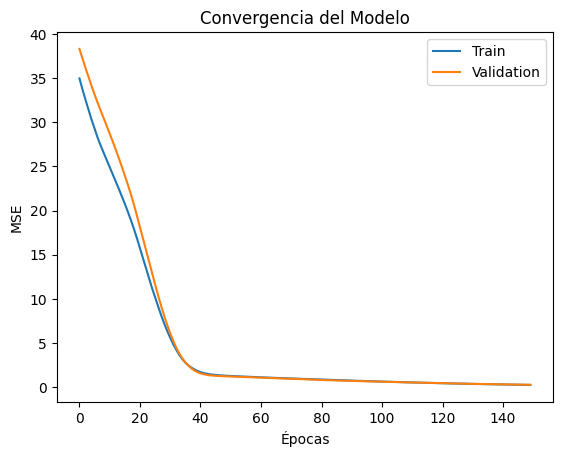

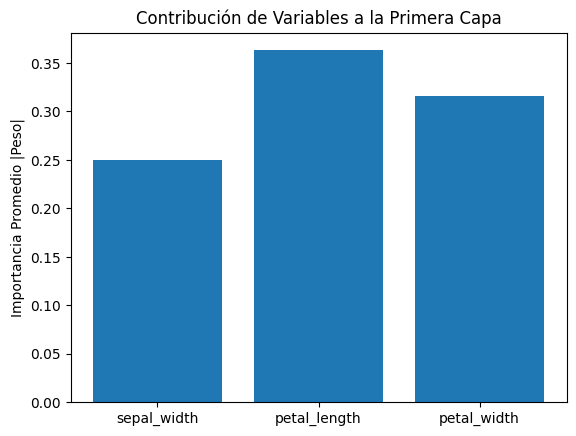

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Datos
# =========================
iris = sns.load_dataset("iris")
X = iris[["sepal_width", "petal_length", "petal_width"]].values
y = iris["sepal_length"].values
feature_names = ["sepal_width", "petal_length", "petal_width"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# =========================
# Modelo
# =========================
model = keras.Sequential([
    layers.Dense(16, activation="relu", input_shape=(3,)),
    layers.Dense(8, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(
    X_train_s,
    y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.2,
    verbose=0
)

# =========================
# 1. Gráfico de Convergencia
# =========================
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Convergencia del Modelo")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend(["Train", "Validation"])
plt.show()

# =========================
# 2. Contribución de Variables (Primera Capa)
# =========================
weights = model.layers[0].get_weights()[0]

contribucion = np.mean(np.abs(weights), axis=1)

df_contrib = pd.DataFrame({
    "Variable": feature_names,
    "Importancia": contribucion
})

plt.figure()
plt.bar(df_contrib["Variable"], df_contrib["Importancia"])
plt.title("Contribución de Variables a la Primera Capa")
plt.ylabel("Importancia Promedio |Peso|")
plt.show()


# Demostración:  
## Sin funciones de activación una red neuronal es regresión lineal múltiple

---

# 1. Red neuronal con una capa oculta

Considere una red con:

- Entrada $x \in \mathbb{R}^p$
- Una capa oculta
- Salida escalar

Modelo general:

$$
a^{(1)} = \phi(W^{(1)}x + b^{(1)})
$$

$$
\hat{y} = W^{(2)} a^{(1)} + b^{(2)}
$$

---

# 2. Supongamos que NO hay función de activación

Es decir,

$$
\phi(z) = z
$$

Entonces:

$$
a^{(1)} = W^{(1)}x + b^{(1)}
$$

Sustituyendo en la salida:

$$
\hat{y}
=
W^{(2)}(W^{(1)}x + b^{(1)}) + b^{(2)}.
$$

---

# 3. Expandimos

$$
\hat{y}
=
W^{(2)}W^{(1)}x
+
W^{(2)}b^{(1)}
+
b^{(2)}.
$$

Definimos:

$$
\beta = W^{(2)}W^{(1)}
$$

$$
\beta_0 = W^{(2)}b^{(1)} + b^{(2)}.
$$

Entonces:

$$
\hat{y}
=
\beta x + \beta_0.
$$

---

# 4. Interpretación

Esto es exactamente el modelo de regresión lineal múltiple:

$$
\hat{y}
=
\beta_0
+
\sum_{j=1}^{p}
\beta_j x_j.
$$

---

# 5. Generalización a múltiples capas

Si todas las capas usan activación identidad:

$$
a^{(l)} = W^{(l)} a^{(l-1)} + b^{(l)},
$$

la composición de transformaciones lineales es nuevamente lineal:

$$
\hat{y}
=
W^{(L)} \cdots W^{(2)} W^{(1)} x
+
\tilde{b}.
$$

Producto de matrices lineales = transformación lineal.

---

Si no existen funciones de activación no lineales:

- La red neuronal completa es una transformación lineal.
- No puede modelar relaciones no lineales.
- Es algebraicamente equivalente a una regresión lineal múltiple.

Por tanto, las funciones de activación son las que introducen la no linealidad y hacen a las redes neuronales modelos más flexibles que la regresión clásica.
